In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import Markdown, display

# Datasets
from aif360.datasets import StandardDataset

# from PhysionetDataset.py import PhysionetDataset.py
# Dataset = PhysionetDataset.py


# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

In [2]:
target_folder = "MoreFavoredProtectedAttributes"
prefix_folder = "MoreFavored"

In [3]:
#PostAcute Treatment Dataset
#https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/N6Z4MV/7UDTMR&version=1.0
np.random.seed(1)

default_mappings = {
    'label_maps': [{1.0: '1'}],
    'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}]
}


filepath = r'C:\Users\sujin\Documents\College\PhD_Project\Project/EditedData/'+ target_folder+'/post_acute_'+ prefix_folder+'_NoCol.csv'
        
filepath2 = r'C:\Users\sujin\Documents\College\PhD_Project\Project/EditedData/'+ target_folder+'/post_acute_'+ prefix_folder+'.csv'
df2 = pd.read_csv(filepath2)
df3=df2
df3.drop(['Age','LOSDAYS', 'BNPChg','BUNChg','GLUCOSEChg','GLYHEMOChg','INRChg','HbAChg','LIVERChg','PLTChg',
          'PTTChg','SRCChg','SRSChg','WBCChg','ALBChg','APHChg','CA19Chg','CO2Chg','LDChg','O2Chg','PCO2Chg',
          'PSAChg','CALChg','SERCHLChg','MAGChg','SERPOTChg','TROChg', "Gender", "readmit30"], axis=1, inplace = True)

categorical_attributes = df3.columns.tolist()



class PostAcuteDataset(StandardDataset):

    def __init__(self, label_name='readmit30',
                 favorable_classes=[1],
                 protected_attribute_names=['Gender'],
                 privileged_classes=[[1]],
                 instance_weights_name=None,
                 categorical_features=categorical_attributes,
                 features_to_keep=[], features_to_drop=[],
                 na_values=[], custom_preprocessing=None,
                 metadata=default_mappings):



        column_names = df2.columns.tolist()
        try:
            df = pd.read_csv(filepath, header=None, names=column_names,
                             na_values=na_values)
            
            #print(df)
        except IOError as err:
            print("IOError: {}".format(err))
            print("To use this class, please download the following files:")
            print("\n\thttps://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data")
            print("\thttps://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc")
            print("\nand place them, as-is, in the folder:")
            print("\n\t{}\n".format(os.path.abspath(os.path.join(
                os.path.abspath(__file__), '..', '..', 'data', 'raw', 'german'))))
            import sys
            sys.exit(1)

        super(PostAcuteDataset, self).__init__(df=df, label_name=label_name,
                                               favorable_classes=favorable_classes,
                                               protected_attribute_names=protected_attribute_names,
                                               privileged_classes=privileged_classes,
                                               instance_weights_name=instance_weights_name,
                                               categorical_features=categorical_features,
                                               features_to_keep=features_to_keep,
                                               features_to_drop=features_to_drop, na_values=na_values,
                                               custom_preprocessing=custom_preprocessing, metadata=metadata)


In [4]:
df2 = pd.read_csv(filepath2)
df = pd.read_csv(filepath, header=None, names=df2.columns)
df.shape
#df.drop(df[df.gender == 'Unknown/Invalid'].index, inplace=True)
#df['gender'] = df['gender'].astype(int)
#df.loc[df['gender'] == 0]



(31029, 192)

In [5]:
# 3.1. Load data & create splits for learning/validating/testing model¶


(dataset_orig_train, dataset_orig_val, dataset_orig_test) = PostAcuteDataset().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_train.unprivileged_protected_attributes[sens_ind]]

privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_train.privileged_protected_attributes[sens_ind]]


def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes,
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)


describe(dataset_orig_train, dataset_orig_val, dataset_orig_test)

metric_orig_train = BinaryLabelDatasetMetric(
    dataset_orig_train,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_train)

print(explainer_orig_panel19_train.disparate_impact())

#### Training Dataset shape

(15486, 512)


#### Validation Dataset shape

(9292, 512)


#### Test Dataset shape

(6195, 512)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Gender']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['Age', 'Gender', 'LOSDAYS', 'BNPChg', 'BUNChg', 'GLUCOSEChg', 'GLYHEMOChg', 'INRChg', 'HbAChg', 'LIVERChg', 'PLTChg', 'PTTChg', 'SRCChg', 'SRSChg', 'WBCChg', 'ALBChg', 'APHChg', 'CA19Chg', 'CO2Chg', 'LDChg', 'O2Chg', 'PCO2Chg', 'PSAChg', 'CALChg', 'SERCHLChg', 'MAGChg', 'SERPOTChg', 'TROChg', 'facility_id=facility 1', 'facility_id=facility 2', 'facility_id=facility 3', 'facility_id=facility 4', 'facility_id=facility 5', 'facility_id=facility 6', 'facility_id=facility 7', 'facility_id=facility 8', 'PatientType=Inpatient', 'MaritalStatus=A', 'MaritalStatus=CIVIL UN', 'MaritalStatus=DIVORCED', 'MaritalStatus=LIFE PAR', 'MaritalStatus=MARRIED', 'MaritalStatus=SINGLE', 'MaritalStatus=WIDOWED', 'Alcohol_Substance_Abuse_cur=0', 'Alcohol_Substance_Abuse_cur=1', 'AMI_cur=0', 'AMI_cur=1', 'Anemia_cur=0', 'Anemia_cur=1', 'Aneurysm_cur=0', 'Aneurysm_cur=1', 'Anxiety_disorder_cur=0', 'Anxiety_disorder_cur=1', 'Asthma_cur=0', 'Asthma_cur=1', 'AV_Fistula_cur=0', 'AV_Fistula_cur=1', 'Cardiac_arrhythm

In [6]:
# 3.2. Learning a Logistic Regression (LR) classifier on original data¶
# 3.2.1. Training LR model on original data

dataset = dataset_orig_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

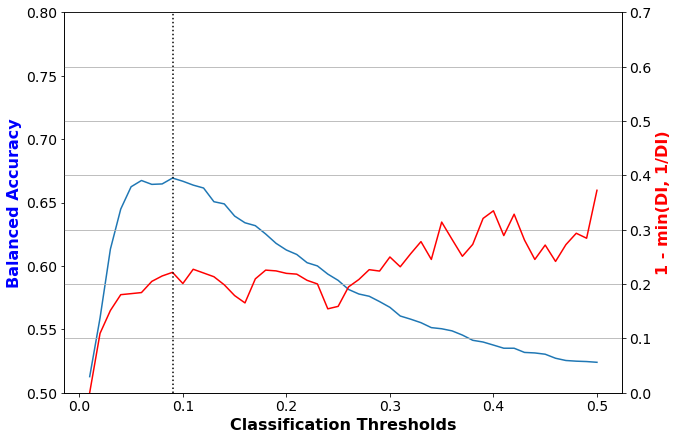

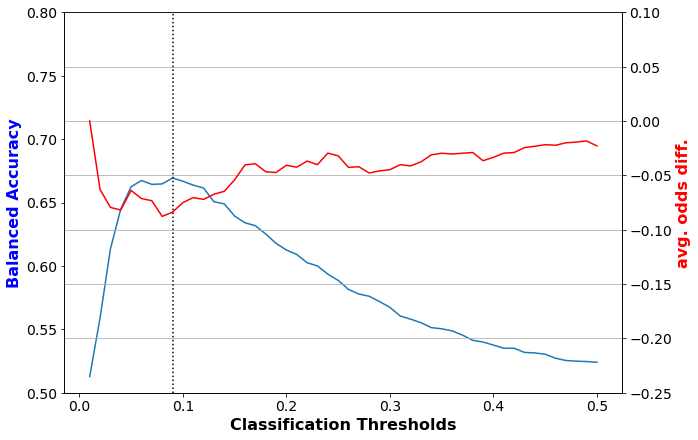

Validation Scores:
Threshold corresponding to Best balanced accuracy: 0.0900
Best balanced accuracy: 0.6693
Corresponding 1-min(DI, 1/DI) value: 0.2216
Corresponding average odds difference value: -0.0838
Corresponding statistical parity difference value: -0.0584
Corresponding equal opportunity difference value: -0.1189
Corresponding Theil index value: 0.0844


In [7]:
# 3.2.2. Validating LR model on original data¶

from collections import defaultdict


def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0

    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
            dataset, dataset_pred,
            unprivileged_groups=unprivileged_groups,
            privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                       + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())

    return metric_arrs


thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_val,
                   model=lr_orig,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])


def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    plt.show()
    
    
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1 / disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))


print("Validation Scores:")
describe_metrics(val_metrics, thresh_arr)

In [8]:
#3.2.3. Testing LR model on original data¶

print("Test Scores:")
lr_orig_metrics = test(dataset=dataset_orig_test,
                       model=lr_orig,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

#4. Bias mitigation using pre-processing technique - Reweighing¶

#4.1. Transform data¶
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)

#Metrics for transformed data

metric_transf_train = BinaryLabelDatasetMetric(
        dataset_transf_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_train = MetricTextExplainer(metric_transf_train)

print(explainer_transf_train.disparate_impact())

Test Scores:
Threshold corresponding to Best balanced accuracy: 0.0900
Best balanced accuracy: 0.6686
Corresponding 1-min(DI, 1/DI) value: 0.1000
Corresponding average odds difference value: -0.0592
Corresponding statistical parity difference value: -0.0257
Corresponding equal opportunity difference value: -0.1005
Corresponding Theil index value: 0.0837
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9999999999999997


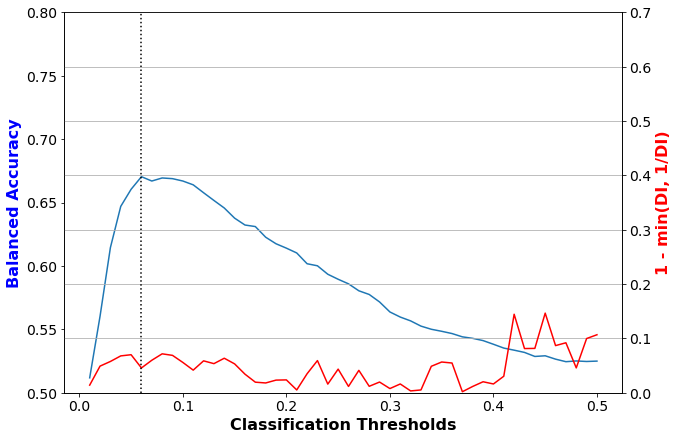

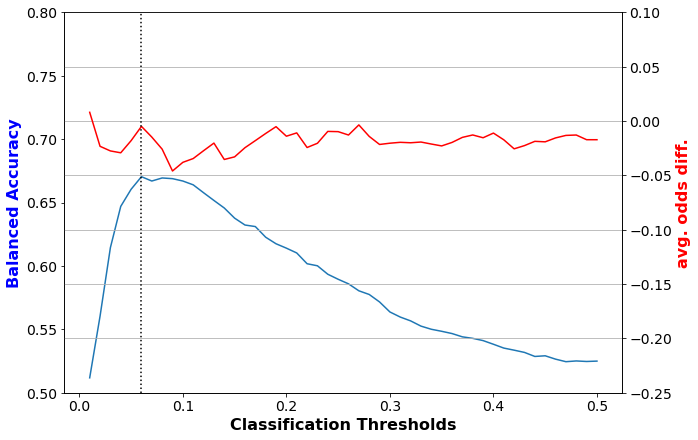

Threshold corresponding to Best balanced accuracy: 0.0600
Best balanced accuracy: 0.6704
Corresponding 1-min(DI, 1/DI) value: 0.0457
Corresponding average odds difference value: -0.0050
Corresponding statistical parity difference value: -0.0179
Corresponding equal opportunity difference value: 0.0042
Corresponding Theil index value: 0.0820


In [9]:
#4.2. Learning a Logistic Regression (LR) classifier on data transformed by reweighing¶

#4.2.1. Training LR model after reweighing¶
dataset = dataset_transf_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#4.2.2. Validating LR model after reweighing¶


thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_val,
                   model=lr_transf,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

describe_metrics(val_metrics, thresh_arr)


In [10]:
#4.2.3. Testing LR model after reweighing¶
lr_transf_metrics = test(dataset=dataset_orig_test,
                         model=lr_transf,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])
describe_metrics(lr_transf_metrics, [thresh_arr[lr_transf_best_ind]])


Threshold corresponding to Best balanced accuracy: 0.0600
Best balanced accuracy: 0.6792
Corresponding 1-min(DI, 1/DI) value: 0.0395
Corresponding average odds difference value: -0.0158
Corresponding statistical parity difference value: -0.0155
Corresponding equal opportunity difference value: -0.0187
Corresponding Theil index value: 0.0800


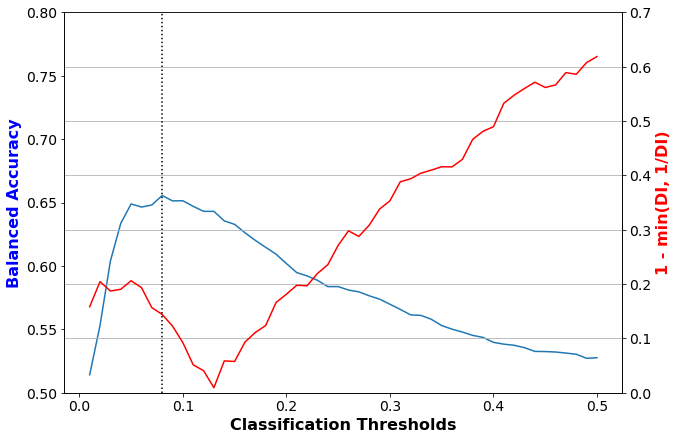

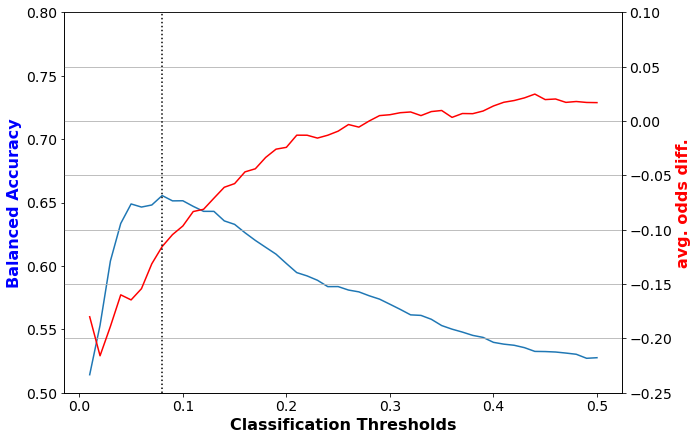

Threshold corresponding to Best balanced accuracy: 0.0800
Best balanced accuracy: 0.6555
Corresponding 1-min(DI, 1/DI) value: 0.1441
Corresponding average odds difference value: -0.1155
Corresponding statistical parity difference value: -0.0428
Corresponding equal opportunity difference value: -0.2046
Corresponding Theil index value: 0.0872


In [11]:
#5. Bias mitigation using in-processing technique - Prejudice Remover (PR)¶

#5.1.1. Training a PR model
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = dataset_orig_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_orig = model.fit(dataset)

#5.1.2. Validating PR model¶

thresh_arr = np.linspace(0.01, 0.50, 50)

dataset = dataset_orig_val.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

val_metrics = test(dataset=dataset,
                   model=pr_orig,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

describe_metrics(val_metrics, thresh_arr)


In [12]:
#5.1.3. Testing PR model¶

dataset = dataset_orig_test.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

pr_orig_metrics = test(dataset=dataset,
                       model=pr_orig,
                       thresh_arr=[thresh_arr[pr_orig_best_ind]])
describe_metrics(pr_orig_metrics, [thresh_arr[pr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.0800
Best balanced accuracy: 0.6512
Corresponding 1-min(DI, 1/DI) value: 0.0859
Corresponding average odds difference value: -0.1603
Corresponding statistical parity difference value: -0.0250
Corresponding equal opportunity difference value: -0.3198
Corresponding Theil index value: 0.0870


In [13]:
import pandas as pd
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            pr_orig_metrics]
debias = pd.Series([''] + ['Reweighing']
                 + ['Prejudice Remover'],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*2 + [''],
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.668554,-0.059170,0.899969,-0.025733,-0.100535,0.083654
Reweighing,Logistic Regression,0.679168,-0.015773,0.960512,-0.015496,-0.018717,0.080030
Prejudice Remover,,0.651164,-0.160265,0.914069,-0.025049,-0.319786,0.086995


In [14]:
#Disparate Impact Remover

from aif360.algorithms.preprocessing import DisparateImpactRemover


In [15]:
#3.2.3. Testing LR model on original data¶

print("Test Scores:")
lr_orig_metrics = test(dataset=dataset_orig_test,
                       model=lr_orig,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

#4. Bias mitigation using pre-processing technique - Disparate Impact Remover¶

#4.1. Transform data¶


di = DisparateImpactRemover(repair_level=0.5)
dataset_transf_train = di.fit_transform(dataset_orig_train)
dataset_transf_test = di.fit_transform(dataset_orig_test)

#Metrics for transformed data

metric_transf_train = BinaryLabelDatasetMetric(
        dataset_transf_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_train = MetricTextExplainer(metric_transf_train)

print(explainer_transf_train.disparate_impact())

Test Scores:
Threshold corresponding to Best balanced accuracy: 0.0900
Best balanced accuracy: 0.6686
Corresponding 1-min(DI, 1/DI) value: 0.1000
Corresponding average odds difference value: -0.0592
Corresponding statistical parity difference value: -0.0257
Corresponding equal opportunity difference value: -0.1005
Corresponding Theil index value: 0.0837
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.8624514979963106


Threshold corresponding to Best balanced accuracy: 0.0800
Best balanced accuracy: 0.6671
Corresponding 1-min(DI, 1/DI) value: 0.4987
Corresponding average odds difference value: -0.1739
Corresponding statistical parity difference value: -0.1461
Corresponding equal opportunity difference value: -0.2116
Corresponding Theil index value: 0.0851


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


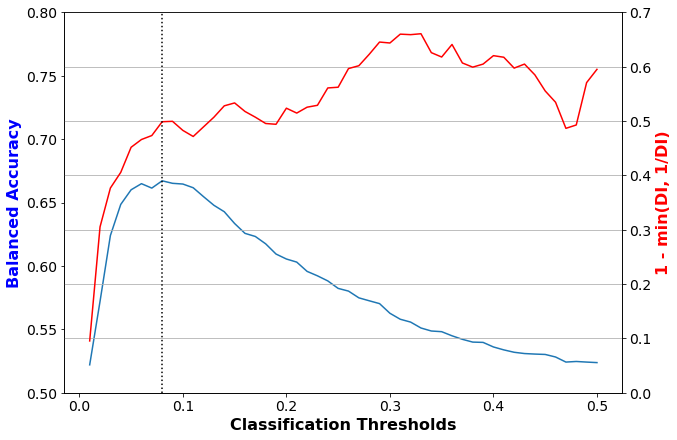

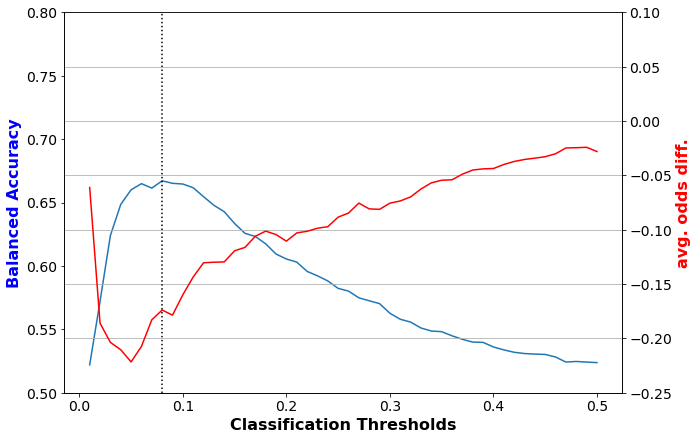

In [16]:
#4.2.1. Training LR model after Disparate Impact Remover¶
dataset = dataset_transf_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#4.2.2. Validating LR model after Disdparate impact Remover¶


thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_val,
                   model=lr_transf,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

describe_metrics(val_metrics, thresh_arr)

In [17]:
#Test LR DIR Model

lr_metrics_DIR = test(dataset=dataset_orig_test,
                         model=lr_transf,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])
describe_metrics(lr_metrics_DIR, [thresh_arr[lr_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.0800
Best balanced accuracy: 0.6726
Corresponding 1-min(DI, 1/DI) value: 0.4195
Corresponding average odds difference value: -0.1482
Corresponding statistical parity difference value: -0.1209
Corresponding equal opportunity difference value: -0.1824
Corresponding Theil index value: 0.0833


In [18]:
import pandas as pd
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            pr_orig_metrics, lr_metrics_DIR]
debias = pd.Series([''] + ['Reweighing']
                 + ['Prejudice Remover'] + ["Disparate Impact Remover"],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*2 + [''] + ["Logistic Regression"],
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.668554,-0.059170,0.899969,-0.025733,-0.100535,0.083654
Reweighing,Logistic Regression,0.679168,-0.015773,0.960512,-0.015496,-0.018717,0.080030
Prejudice Remover,,0.651164,-0.160265,0.914069,-0.025049,-0.319786,0.086995
Disparate Impact Remover,Logistic Regression,0.672605,-0.148161,0.580499,-0.120932,-0.182353,0.083321


In [19]:
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
from aif360.metrics import ClassificationMetric
from sklearn.preprocessing import MaxAbsScaler
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()


# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.011103
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.006293


In [20]:
min_max_scaler = MaxAbsScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())

#### Scaled dataset - Verify that the scaling does not affect the group label statistics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.011103
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.006293


In [21]:
#Learn plan classifier without debiasing
# Load post-processing algorithm that equalizes the odds
# Learn parameters with debias set to False
sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)

plain_model.fit(dataset_orig_train)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 0.790669
epoch 1; iter: 0; batch classifier loss: 0.152472
epoch 2; iter: 0; batch classifier loss: 0.276690
epoch 3; iter: 0; batch classifier loss: 0.242377
epoch 4; iter: 0; batch classifier loss: 0.236558
epoch 5; iter: 0; batch classifier loss: 0.324156
epoch 6; iter: 0; batch classifier loss: 0.241289
epoch 7; iter: 0; batch classifier loss: 0.157006
epoch 8; iter: 0; batch classifier loss: 0.146457
epoch 9; iter: 0; batch classifier loss: 0.146220
epoch 10; iter: 0; batch classifier loss: 0.266809
epoch 11; iter: 0; batch classifier loss: 0.182653
epoch 12; iter: 0; batch classifier loss: 0.275211
epoch 13; iter: 0; batch classifier loss: 0.293620
epoch 14; iter: 0; batch classifier loss: 0.247432
epoch 15; iter: 0; batch classifier loss: 0.431186
epoch 16; iter: 0; batch classifier loss: 0.188936
epoch 17; iter: 0; batch classifier loss: 0.195102
epoch 18; iter: 0; batch classifier loss: 0.229111
epoch 19; iter: 0; batch classifier loss:

In [22]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)

In [23]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

display(Markdown("#### Plain model - without debiasing - classification metrics"))
classified_metric_nodebiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_nodebiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Statisticsal parity difference = %f" % classified_metric_nodebiasing_test.statistical_parity_difference())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

metrics_AD = defaultdict(list,
            {'bal_acc': [bal_acc_nodebiasing_test],
             'avg_odds_diff': [classified_metric_nodebiasing_test.average_odds_difference()],
             'disp_imp': [classified_metric_nodebiasing_test.disparate_impact()],
             'stat_par_diff': [classified_metric_nodebiasing_test.statistical_parity_difference()],
             'eq_opp_diff': [classified_metric_nodebiasing_test.equal_opportunity_difference()],
             'theil_ind': [classified_metric_nodebiasing_test.theil_index()]})


#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.010627
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.002465


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.908959
Test set: Balanced classification accuracy = 0.527927
Test set: Average odds difference = -0.010845
Test set: Disparate impact = 1.086771
Test set: Statisticsal parity difference = 0.002465
Test set: Equal opportunity difference = -0.026738
Test set: Theil_index = 0.079531


In [24]:
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            pr_orig_metrics, lr_metrics_DIR, metrics_AD]
debias = pd.Series([''] + ['Reweighing']
                 + ['Prejudice Remover'] + ["Disparate Impact Remover"] + ["Adversarial Debias"],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*2 + [''] + ["Logistic Regression"] + ["No Debias"],
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.668554,-0.059170,0.899969,-0.025733,-0.100535,0.083654
Reweighing,Logistic Regression,0.679168,-0.015773,0.960512,-0.015496,-0.018717,0.080030
Prejudice Remover,,0.651164,-0.160265,0.914069,-0.025049,-0.319786,0.086995
Disparate Impact Remover,Logistic Regression,0.672605,-0.148161,0.580499,-0.120932,-0.182353,0.083321
Adversarial Debias,No Debias,0.527927,-0.010845,1.086771,0.002465,-0.026738,0.079531


In [25]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)
debiased_model.fit(dataset_orig_train)


epoch 0; iter: 0; batch classifier loss: 1.005921; batch adversarial loss: 0.628476
epoch 1; iter: 0; batch classifier loss: 0.228544; batch adversarial loss: 0.664401
epoch 2; iter: 0; batch classifier loss: 0.239846; batch adversarial loss: 0.630893
epoch 3; iter: 0; batch classifier loss: 0.137879; batch adversarial loss: 0.609909
epoch 4; iter: 0; batch classifier loss: 0.184662; batch adversarial loss: 0.600251
epoch 5; iter: 0; batch classifier loss: 0.266332; batch adversarial loss: 0.551906
epoch 6; iter: 0; batch classifier loss: 0.292036; batch adversarial loss: 0.529793
epoch 7; iter: 0; batch classifier loss: 0.254041; batch adversarial loss: 0.551974
epoch 8; iter: 0; batch classifier loss: 0.299412; batch adversarial loss: 0.455583
epoch 9; iter: 0; batch classifier loss: 0.227902; batch adversarial loss: 0.446104
epoch 10; iter: 0; batch classifier loss: 0.216175; batch adversarial loss: 0.554198
epoch 11; iter: 0; batch classifier loss: 0.317012; batch adversarial loss:

In [26]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

In [27]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())



display(Markdown("#### Plain model - without debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())





display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())

metrics_AD2 = defaultdict(list,
            {'bal_acc': [bal_acc_debiasing_test],
             'avg_odds_diff': [classified_metric_debiasing_test.average_odds_difference()],
             'disp_imp': [classified_metric_debiasing_test.disparate_impact()],
             'stat_par_diff': [classified_metric_debiasing_test.statistical_parity_difference()],
             'eq_opp_diff': [classified_metric_debiasing_test.equal_opportunity_difference()],
             'theil_ind': [classified_metric_debiasing_test.theil_index()]})

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.010627
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.002465


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.017763
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.005146


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.908959
Test set: Balanced classification accuracy = 0.527927
Test set: Disparate impact = 1.086771
Test set: Equal opportunity difference = -0.026738
Test set: Average odds difference = -0.010845
Test set: Theil_index = 0.079531


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.918805
Test set: Balanced classification accuracy = 0.522221
Test set: Disparate impact = 0.688475
Test set: Equal opportunity difference = -0.026203
Test set: Average odds difference = -0.014729
Test set: Theil_index = 0.077022


In [28]:
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            lr_metrics_DIR,pr_orig_metrics, metrics_AD, metrics_AD2]
debias = pd.Series(['None'] + ['Reweighing']
                 + ["Disparate Impact Remover"] + ['Prejudice Remover']+ ["Adversarial Debias"]*2,
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*4 + ["GD(No Debias)"] +["GD(Debased)"],
                name='Classifier')
final_df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])
final_df

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
None,Logistic Regression,0.668554,-0.059170,0.899969,-0.025733,-0.100535,0.083654
Reweighing,Logistic Regression,0.679168,-0.015773,0.960512,-0.015496,-0.018717,0.080030
Disparate Impact Remover,Logistic Regression,0.672605,-0.148161,0.580499,-0.120932,-0.182353,0.083321
Prejudice Remover,Logistic Regression,0.651164,-0.160265,0.914069,-0.025049,-0.319786,0.086995
Adversarial Debias,GD(No Debias),0.527927,-0.010845,1.086771,0.002465,-0.026738,0.079531
Adversarial Debias,GD(Debased),0.522221,-0.014729,0.688475,-0.005146,-0.026203,0.077022


In [31]:
final_df.to_pickle("PostAcute_Results_"+ prefix_folder+"_P_Pickle")


In [32]:
pickle = pd.read_pickle("PostAcute_Results_"+ prefix_folder+"_P_Pickle")
pickle

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
None,Logistic Regression,0.668554,-0.059170,0.899969,-0.025733,-0.100535,0.083654
Reweighing,Logistic Regression,0.679168,-0.015773,0.960512,-0.015496,-0.018717,0.080030
Disparate Impact Remover,Logistic Regression,0.672605,-0.148161,0.580499,-0.120932,-0.182353,0.083321
Prejudice Remover,Logistic Regression,0.651164,-0.160265,0.914069,-0.025049,-0.319786,0.086995
Adversarial Debias,GD(No Debias),0.527927,-0.010845,1.086771,0.002465,-0.026738,0.079531
Adversarial Debias,GD(Debased),0.522221,-0.014729,0.688475,-0.005146,-0.026203,0.077022
